# Regression with custom priors

##### Keywords: regression, priors, uninformative priors, MCMC, bayesian, jeffreys prior

## Contents
{:.no_toc}
* 
{: toc}

## Summary

Based on an example from the pymc3 docs and Jake Vanderplas's must-read blog article at http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/ , we do in pymc a custom regression with uninformative priors. We cover how to create custom densities and how to use theano shared variables to get posterior predictives.

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Generate Data

This example is adapted from the pymc3 tutorial

In [2]:
np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

We'll take a detour to be able to posterior predict elsewhere

In [3]:
from theano import shared
xdata_shared = shared(xdata)

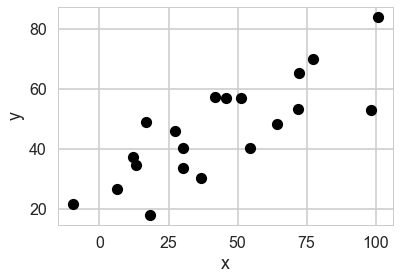

In [4]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

In [5]:
import pymc3 as pm

## Jeffrey's priors

What do we do for priors of scale variables, such as the precision/variance of a gaussian?

The point of Jeffreys Priors is to create priors that don’t become informative when you transform the variables. Jeffreys Priors are defined as:

$$p_J(\theta)\propto {\bf I}(\theta)^{1/2}$$

The Fisher Information $I$ is the second derivative of the likelihood surface and thus represents the curvature of that surface:

$${\bf I}(\theta)=det(−E\left[ \frac{d^{2} \log p(X \vert \theta)}{d\theta_i\theta_j} \right])$$

where the expectation is with respect to the sampling distribution (the likelihood as a distribution).

You can convince yourself that $p_J$ is invariant under a change of variable, unlike the uniform prior; this is particularly easy to show in one dimension.

### Jeffrey’s priors for the gaussian-gaussian model

For a gaussian with known $\sigma$ (see the normal model), lets find the Jeffrey’s prior for the location parameter $\mu$:

$$I \propto E_{f\vert\sigma} \left[\frac{1}{\sigma^2}\right] = \frac{1}{\sigma^2}$$

(by $f \mid \sigma$ we mean holding $\sigma$ fixed or likelihood as a function of $\mu$)

The Jeffrey’s prior for $\mu$ is thus $1/\sigma$ and for fixed $\sigma$ this is the improper uniform….

What about for $\sigma$:

Then:

$$I  = E_{f \vert \mu}\left[\frac{d^2}{d\sigma^2}( log(\sigma) +(x-\mu)^2/2\sigma^2)\right] = E_{f \vert \mu}\left[-\frac{1}{\sigma^2} + 3 \frac{(x-\mu)^2}{\sigma^4}\right] = \frac{2}{\sigma^2}$$

which makes the prior $1/\sigma$.

## Writing the model

$$
\alpha \sim Uniform(-100,100)\\
\beta \sim (1 + \beta^2)^{-3/2}\\
\sigma \sim 1/\sigma \\
\mu = \alpha + \beta x\\
y \sim N(\mu, \sigma)
$$

### Setting priors

Where do the priors for $\sigma$ and $\beta$ come from? The prior for $\sigma$, as we have seen earlier, is the Jeffrey's prior on $\sigma$ the scale parameter for a normal-normal model.

The prior on $\beta$ the slope (remember, we dont want to put a uniform prior on slope) can be derived as an uninformative prior based on symmetry, say:

$$y = \alpha + \beta x ; x = \alpha^{'} + \beta^{'} y$$

Thus $\alpha^{'} = \beta/\alpha$, and $\beta^{'} = 1/\beta$.

The jacobian of the transformation is $\beta^3$ so that $q(\alpha^{'}, \beta^{'}) = \beta^3 p(\alpha, \beta)$ where $q$ is the pdf in the transformed variables. But now we want uninformativeness, or that the transformation should not affect the pdf, and we can check that the prior we chose makes $q=p$ in functional form:

$$p(-\alpha/\beta, 1/\beta) = \beta^3 p(\alpha, \beta)$$

We will need to write custom densities for this. Theano provides us a way:

In [14]:
import theano.tensor as T

with pm.Model() as model1:
    alpha = pm.Normal('intercept', 0, 100)

    # Create custom densities, you must supply logp
    beta = pm.DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=10)
    eps = pm.DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=10)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * (xdata_shared - xdata_shared.mean()), sd=eps, observed=ydata)

In [15]:
for RV in model1.basic_RVs:
    print(RV.name, RV.logp(model1.test_point))

intercept -5.524108719192764
beta -6.92268077526189
eps -2.302585092994046
y_est -8385.484891686912


## Sampling

And now we sample..

In [16]:
with model1:
    stepper=pm.Metropolis()
    tracem1 = pm.sample(100000, step=stepper, njobs=2)
    #tracem1 = pm.sample(4000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [beta]
>Metropolis: [intercept]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [eps]
>Metropolis: [beta]
>Metropolis: [intercept]
100%|██████████| 100500/100500 [00:51<00:00, 1933.72it/s]
The number of effective samples is smaller than 25% for some parameters.


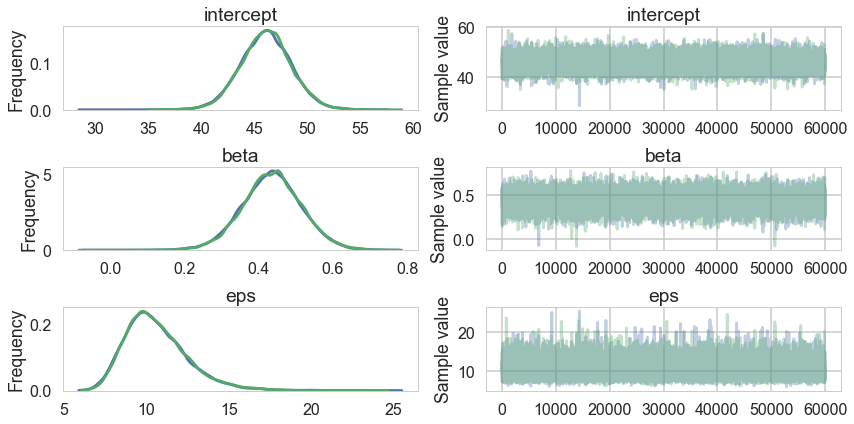

In [17]:
tm1=tracem1[40000::]
pm.traceplot(tm1);

In [18]:
pm.summary(tm1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,46.082865,2.412582,0.013754,41.331279,50.789888,25957.0,1.000042
beta,0.433899,0.081065,0.000531,0.274618,0.595071,25344.0,0.999998
eps,10.634574,1.915740,0.015013,7.312843,14.458126,17637.0,1.000025


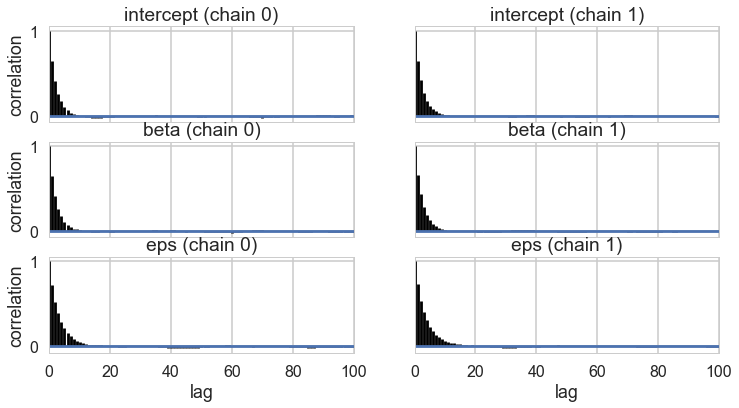

In [19]:
pm.autocorrplot(tm1);

In [20]:
pm.trace_to_dataframe(tm1).corr()

,intercept,beta,eps
intercept,1.000000,0.001150,0.004989
beta,0.001150,1.000000,-0.042344
eps,0.004989,-0.042344,1.000000


## Results

In [26]:
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model"""
    ax.plot(xdata, ydata, 'ok')

    intercept, beta = trace['intercept'][:,None], trace['beta'][:,None]
    xfit = np.linspace(-20, 120, 10)
    yfit = intercept + beta * (xfit - xfit.mean())
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [27]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

In [28]:
def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace['intercept'], trace['beta'])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace['intercept'], trace['beta'], ',k', alpha=0.1)
    ax.set_xlabel(r'intercept')
    ax.set_ylabel(r'$\beta$')

In [29]:
def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

We can plot our posterior contours and see how the posterior reacts to our data.

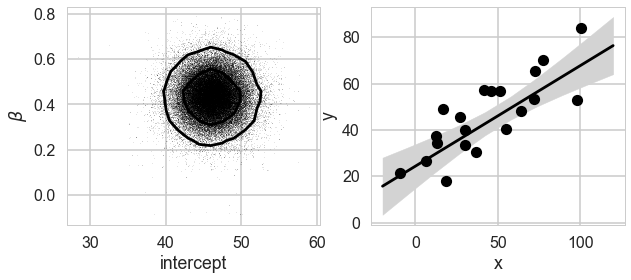

In [30]:
plot_MCMC_results(xdata, ydata, tm1)

### Gewecke convergence test

Our sample-runs give use per-run z scores for the difference of means wau=y within the 1 to -1 bracket.

In [36]:
z = pm.geweke(tm1, intervals=100);

(0, 1000)

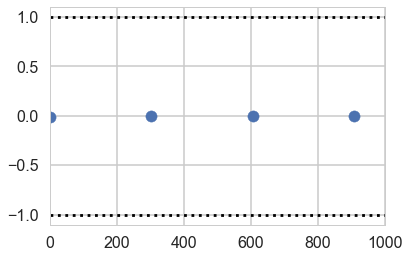

In [37]:
plt.scatter(*z[0]['intercept'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

(0, 1000)

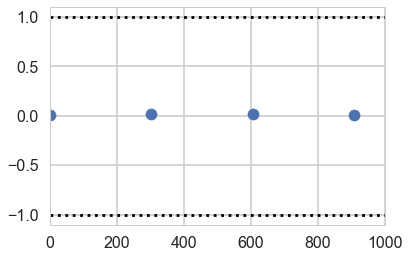

In [38]:
plt.scatter(*z[0]['beta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

(0, 1000)

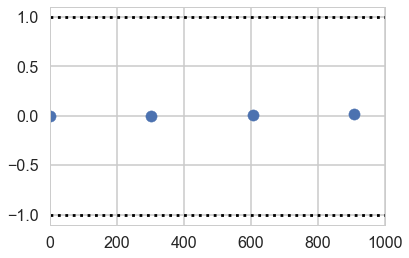

In [39]:
plt.scatter(*z[1]['eps'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

## Getting the posterior predictive

In [40]:
xdata_oos=np.arange(-20, 120,1) #out of sample
xdata_shared.set_value(xdata_oos)

In [41]:
ppc = pm.sample_ppc(tm1, model=model1, samples=500)

100%|██████████| 500/500 [00:03<00:00, 146.72it/s]


In [42]:
ppc['y_est'].shape, xdata.shape, xdata_oos.shape

((500, 140), (20,), (140,))

In [43]:
yppc = ppc['y_est'].mean(axis=0)
yppcstd=ppc['y_est'].std(axis=0)


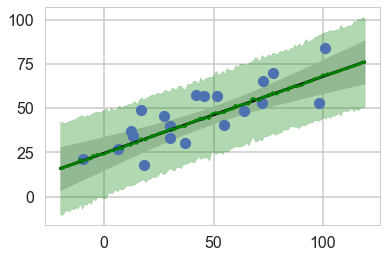

In [45]:
plt.plot(xdata, ydata,'o');
intercept, beta = tm1['intercept'][:,None], tm1['beta'][:,None]
yfit = intercept + beta * (xdata_oos - xdata_oos.mean())
mu = yfit.mean(0)
sig = 2 * yfit.std(0)
plt.plot(xdata_oos, mu, '-k')
plt.fill_between(xdata_oos, mu - sig, mu + sig, color='lightgray')
plt.plot(xdata_oos, yppc, color="green")
plt.fill_between(xdata_oos, yppc - 2*yppcstd, yppc + 2*yppcstd, color='green', alpha=0.3)
